## **Training GANs to Paint**
Jeffrey Yoo, Sam Nadjari, Clark Benham

For this project, we aim to train GAN that can generate paintings that resembled the paintings of great historical artists. We used a dataset that contains some of the most famous historical paintings. 

Dataset link: https://www.kaggle.com/ikarus777/best-artworks-of-all-time

We initially tried training GAN based on Deep Convolution GAN paper and Goodfellow's original paper on GANS. However, we quickly discovered that mode collapse, which is a common problem of GAN training, occured. Therefore, we tried training Wassterstein GAN to resolve this issue.




In [1]:
# Mount personal google drive that has data
from google.colab import drive
drive.mount('/content/drive')  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! unzip -o /content/drive/My\ Drive/comp-vision-project/resized.zip >/dev/null && mv resized data

In [0]:
# Directory settings
project_dir = "/content/drive/My Drive/comp-vision-project"
data_dir = "/content/data"

In [0]:
#----------------------------------------------------#
#------------------ ART DATASET ---------------------#
#----------------------------------------------------#
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ArtDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.file_list = list(filter(lambda x: ".jpg" in x, os.listdir(data_dir)))
        self.transform = transform

    def parse_artist_name(self, file_name):
        lastUnderScore = -1
        for i, c in enumerate(reversed(file_name)):
            if c == "_":
                lastUnderScore = i+1
                break;
        return file_name[0:-1*lastUnderScore]

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_name = self.data_dir + "/" + self.file_list[idx]
        image = Image.open(img_name)
        #category = category_map[self.parse_artist_name(self.file_list[idx])]
        category = 1 #0 if img is from dataset. 1 if otherwise

        if self.transform:
            image = self.transform(image)

        return image, category

# **Original GAN**

In [0]:
#----------------------------------------------------#
#-------------- ORIGINAL GAN MODELS -----------------#
#----------------------------------------------------#

#CREDIT: Models adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, num_z, num_feat):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(num_z, num_feat * 8, 4, 1, 0, bias=False),
                        nn.BatchNorm2d(num_feat * 8),
                        nn.ReLU(True)
                    )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(num_feat*8, num_feat * 4, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 4),
                        nn.ReLU(True)
                    )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(num_feat * 4, num_feat * 2, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 2),
                        nn.ReLU(True)
                    )
        self.layer4 = nn.Sequential(
                        nn.ConvTranspose2d(num_feat * 2, num_feat, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 1),
                        nn.ReLU(True)
                    )
        self.layer5 = nn.Sequential(
                        nn.ConvTranspose2d(num_feat * 1, num_feat//2, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat//2),
                        nn.ReLU(True)
                    )
        self.final_layer = nn.Sequential(
                        nn.ConvTranspose2d(num_feat//2, 3, 4, 2, 1, bias=False),
                        nn.Tanh()
                    )

    def forward(self, x):
        x1 = self.layer1(x)
        #print("layer-1:",x1.shape)
        x2 = self.layer2(x1)
        #print("layer-2:",x2.shape)
        x3 = self.layer3(x2)
        #print("layer-3:",x3.shape)
        x4 = self.layer4(x3)
        #print("layer-4:",x4.shape)
        x5 = self.layer5(x4)
        #print("layer-5:",x5.shape)
        y = self.final_layer(x5)

        return y


class Discriminator(nn.Module):
    def __init__(self, num_z, num_feat):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, num_feat, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat),
                        nn.LeakyReLU(0.2, inplace=True)
                    )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(num_feat, num_feat * 2, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 2),
                        nn.LeakyReLU(0.2, inplace=True)
                    )
        self.layer3 = nn.Sequential(
                        nn.Conv2d(num_feat * 2, num_feat * 4, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 4),
                        nn.LeakyReLU(0.2, inplace=True)
                    )
        self.layer4 = nn.Sequential(
                        nn.Conv2d(num_feat * 4, num_feat * 8, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 8),
                        nn.LeakyReLU(0.2, inplace=True)
                    )
        self.layer5 = nn.Sequential(
                        nn.Conv2d(num_feat * 8, 1, 4, 1, 0, bias=False),   
                        nn.LeakyReLU(0.2, inplace=True)
                    )
        self.final_layer = nn.Sequential(
                        nn.MaxPool2d(5),
                        nn.Sigmoid()
                    )

    def forward(self, x):
        x1 = self.layer1(x)
        #print("layer1:", x1.size())
        x2 = self.layer2(x1)
        #print("layer2:", x2.size())
        x3 = self.layer3(x2)
        #print("layer3:", x3.size())
        x4 = self.layer4(x3)
        #print("layer4:", x4.size())
        x5 = self.layer5(x4)
        #print("layer5:", x5.size())
        y = self.final_layer(x5)
        return y

In [0]:

#----------------------------------------------------#
#-------------- ORIGINAL GAN TRAINING ---------------#
#----------------------------------------------------#

#CREDIT: Training code taken from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

############### Imports ############### 
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

############### Settings ###############
batch_size = 64
image_size = 128
num_c = 3
num_z = 100
num_featG = 128
num_featD = 128
num_epochs = 10
lr = 0.0002
beta1 = 0.5
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, num_z, 1, 1, device=device)
real_label = 1
fake_label = 0

dataset = ArtDataset(data_dir,
            transform=transforms.Compose([
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean = [0.485, 0.456, 0.406],
                    std = [0.229, 0.224, 0.225]
                )
            ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Setup Adam optimizers for both G and D


############### Methods ###############
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def train(netG, netD):
    print("Start training...")
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    for epoch in range(num_epochs):
    # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            # Train with batch from actual dataset
            netD.zero_grad()
            real_batch = data[0].to(device)
            batchSize = real_batch.size(0)
            label = torch.full((batchSize,), real_label, device=device)

            output = netD(real_batch).view(-1)
            errD_real = criterion(output, label)
            
            errD_real.backward()
            D_x = output.mean().item()   # D(x) part of the V(D,G)

            ## Train with all-fake batch
            noise = torch.randn(batchSize, num_z, 1, 1, device=device)
            fake_batch = netG(noise)
            label.fill_(fake_label)
            output = netD(fake_batch.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake_batch).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        
            iters += 1
    print("Finished training!")

    return netG, netD, G_losses, D_losses

In [7]:
# Execute training for original GAN
import time

# Create our generator and discriminator
netG = Generator(num_z, num_featG).to(device)
netD = Discriminator(num_z, num_featD).to(device)

# Weight initialize
netG.apply(weights_init)
netD.apply(weights_init)

# Train models
torch.cuda.empty_cache()
netG, netD, lossG, lossD = train(netG, netD)

# Save trained models
saved_dir = project_dir + "/saved"
t = int(time.time())
torch.save(netG.state_dict(), saved_dir + "/gen_model_dict-" + str(t))
torch.save(netD.state_dict(), saved_dir + "/disc_model_dict-" + str(t))

Start training...
[0/10][0/126]	Loss_D: 2.5134	Loss_G: 0.7122	D(x): 0.8070	D(G(z)): 0.8717 / 0.5132
[0/10][50/126]	Loss_D: 2.3592	Loss_G: 1.7992	D(x): 0.1954	D(G(z)): 0.2086 / 0.1668
[0/10][100/126]	Loss_D: 1.5889	Loss_G: 2.8016	D(x): 0.5924	D(G(z)): 0.5011 / 0.0613
[1/10][0/126]	Loss_D: 2.6994	Loss_G: 3.2610	D(x): 0.3033	D(G(z)): 0.5280 / 0.0458
[1/10][50/126]	Loss_D: 1.3362	Loss_G: 4.1072	D(x): 0.7136	D(G(z)): 0.5168 / 0.0165
[1/10][100/126]	Loss_D: 0.7262	Loss_G: 1.7494	D(x): 0.8275	D(G(z)): 0.3626 / 0.1749
[2/10][0/126]	Loss_D: 0.6818	Loss_G: 2.1643	D(x): 0.8556	D(G(z)): 0.3695 / 0.1154
[2/10][50/126]	Loss_D: 0.5095	Loss_G: 2.6737	D(x): 0.9053	D(G(z)): 0.3000 / 0.0694
[2/10][100/126]	Loss_D: 0.8800	Loss_G: 2.3212	D(x): 0.8284	D(G(z)): 0.3597 / 0.0983
[3/10][0/126]	Loss_D: 1.0926	Loss_G: 1.7744	D(x): 0.7501	D(G(z)): 0.3931 / 0.1698
[3/10][50/126]	Loss_D: 0.5609	Loss_G: 2.8019	D(x): 0.8809	D(G(z)): 0.2864 / 0.0617
[3/10][100/126]	Loss_D: 0.1344	Loss_G: 3.4426	D(x): 0.9524	D(G(z)): 0.

In [0]:
# Some utility functions

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
import numpy as np

def display_output(output):
    #Show output of generator
    img = transforms.ToPILImage()(output)
    plt.imshow(img)
    plt.grid('off')
    plt.axis('off')

def display_multiple_output(outputs):
    imgs = [transforms.ToPILImage()(output) for output in outputs]
    plt.figure(figsize = (12, 12))
    plt.imshow(np.concatenate(imgs, axis=1))
    plt.grid('off')
    plt.axis('off')

def load_latest_model():
    saved_dir = project_dir + "/saved"
    listDict = os.listdir(saved_dir)
    latest = None
    for f in listDict:
        if "gen_model" in f and f > latest:
            latest = f
    model = Generator(num_z, num_feat)
    model.load_state_dict(torch.load(saved_dir + "/" + latest))
    return model

def load_model(time):
    saved_dir = project_dir + "/saved"
    model = Generator(num_z, num_featG)
    model.load_state_dict(torch.load(saved_dir + "/gen_model_dict" + w + "-" + time))
    return model

def load_wmodel(time, w=""):
    saved_dir = project_dir + "/saved"
    model = Generator(64, num_featG)
    model.load_state_dict(torch.load(saved_dir + "/gen_model_dict_w-" + time))
    return model

def plot_loss(lossG, lossD, model_name):
    plt.figure(figsize=(12,7))
    plt.xlabel('Iterations')  
    plt.ylabel('Loss')
    plt.title(model_name + ' Error vs. Training Iterations')
    iters = [i for i in range(1,len(lossG)+1)]
    plt.plot(iters, lossG)
    plt.plot(iters, lossD)
    plt.legend(['G loss', 'D loss'], loc='upper left')

Noise input 1, 2, 3


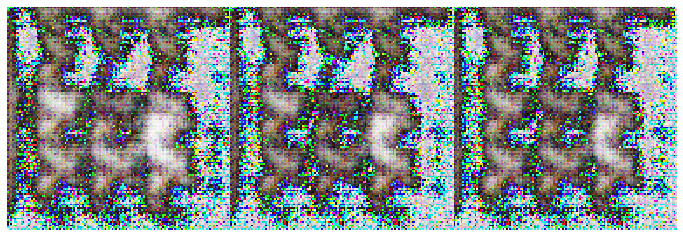

In [17]:
# Evidence 1 of mode collapse
dict_ID_1 = "1574742440"
model_collapse_model_1 = load_model(dict_ID_1).to(device)
z = torch.randn(3, 100, 1, 1).to(device)
output = model_collapse_model_1(z)

print("Noise input 1, 2, 3")
display_multiple_output(output.cpu())

Noise input 1, 2, 3


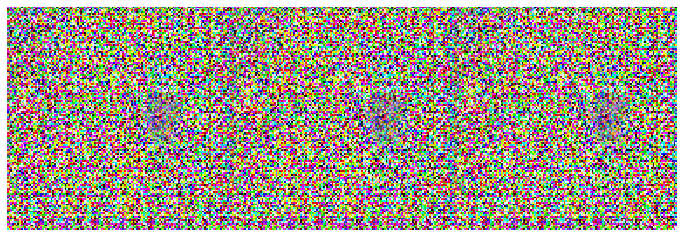

In [18]:
# Evidence 2 of mode collapse
dict_ID_2 = "1574915605"
model_collapse_model_2 = load_model(dict_ID_2).to(device)
z = torch.randn(3, 100, 1, 1).to(device)
output = model_collapse_model_2(z)

print("Noise input 1, 2, 3")
display_multiple_output(output.cpu())

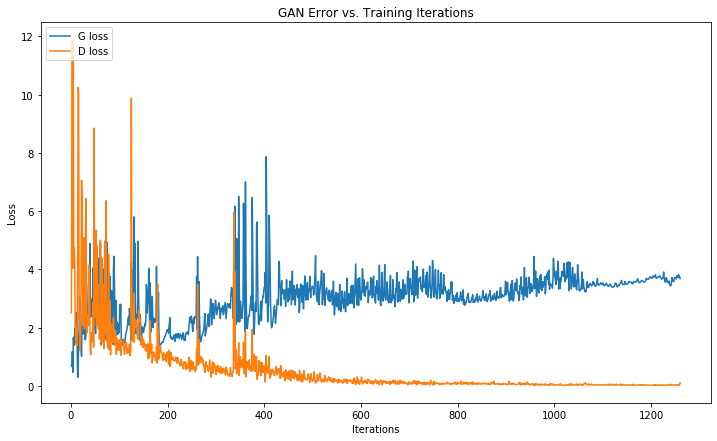

In [19]:
plot_loss(lossG, lossD, "GAN")

In both evidence 1 and evidence 2, we can see here that even though we input three different noise inputs, our outputs are still very similar. This is a case of mode collapse, where our generative model is only fitted to produce samples only from a very small part of the image features space. This resolve this issue, we turn to Wasserstein GAN (WGAN), which is thoughted to be easier to train.

# **Wasserstein GAN**

In [0]:
#----------------------------------------------------#
#-------------- Wasserstein GAN MODELS --------------#
#----------------------------------------------------#
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, num_z, num_feat):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(num_z, num_feat * 8, 4, 1, 0, bias=False),
                        nn.BatchNorm2d(num_feat * 8),
                        nn.ReLU(True)
                    )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(num_feat*8, num_feat * 4, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 4),
                        nn.ReLU(True)
                    )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(num_feat * 4, num_feat * 2, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 2),
                        nn.ReLU(True)
                    )
        self.layer4 = nn.Sequential(
                        nn.ConvTranspose2d(num_feat * 2, num_feat, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 1),
                        nn.ReLU(True)
                    )
        self.layer5 = nn.Sequential(
                        nn.ConvTranspose2d(num_feat * 1, num_feat//2, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat//2),
                        nn.ReLU(True)
                    )
        self.final_layer = nn.Sequential(
                        nn.ConvTranspose2d(num_feat//2, 3, 4, 2, 1, bias=False),
                        nn.Tanh()
                    )

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        y = self.final_layer(x5)

        return y


class Discriminator(nn.Module):
    def __init__(self, num_z, num_feat):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, num_feat, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat),
                        nn.LeakyReLU(0.2, inplace=True)
                    )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(num_feat, num_feat * 2, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 2),
                        nn.LeakyReLU(0.2, inplace=True)
                    )
        self.layer3 = nn.Sequential(
                        nn.Conv2d(num_feat * 2, num_feat * 4, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 4),
                        nn.LeakyReLU(0.2, inplace=True)
                    )
        self.layer4 = nn.Sequential(
                        nn.Conv2d(num_feat * 4, num_feat * 8, 4, 2, 1, bias=False),
                        nn.BatchNorm2d(num_feat * 8),
                        nn.LeakyReLU(0.2, inplace=True)
                    )
        self.layer5 = nn.Sequential(
                        nn.Conv2d(num_feat * 8, 1, 4, 1, 0, bias=False),   
                        nn.LeakyReLU(0.2, inplace=True)
                    )
        self.final_layer = nn.Sequential(
                        nn.MaxPool2d(5),
                        nn.ReLU() # Remove sigmoid activation
                    )

    def forward(self, x):
        x1 = self.layer1(x)
        #print("layer1:", x1.size())
        x2 = self.layer2(x1)
        #print("layer2:", x2.size())
        x3 = self.layer3(x2)
        #print("layer3:", x3.size())
        x4 = self.layer4(x3)
        #print("layer4:", x4.size())
        x5 = self.layer5(x4)
        #print("layer5:", x5.size())
        y = self.final_layer(x5)

        return y


In [0]:
#----------------------------------------------------#
#-------------- Wasserstein GAN TRAINING ------------#
#----------------------------------------------------#

############### Imports ############### 
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

############### Settings ###############
batch_size = 64
image_size = 128
critic_step_size = 2  # The number of iterations we will train the critic
gen_step_size = 1
num_c = 3
num_z = 64
num_featG = 128
num_featD = 128
num_epochs = 10
lr = 0.0000005
clip_limit = 0.001
beta1 = 0.5
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
fixed_noise = torch.randn(64, num_z, 1, 1, device=device)
real_label = 1
fake_label = 0

dataset = ArtDataset(data_dir,
            transform=transforms.Compose([
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean = [0.485, 0.456, 0.406],
                    std = [0.229, 0.224, 0.225]
                )
            ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


############### Methods ###############
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def W_train(netG, netD):
    print("Start training...")

    # Unlike original GAN, use RMSprop optimizer
    optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
    optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    for epoch in range(num_epochs):
    # For each batch in the dataloader
        i = 0
        iterloader = iter(dataloader)
        while i < len(dataloader):
            if i >= len(dataloader):
                    break
            #print("Batch", i, "training...")
            # Unlike original GAN, we train D for a few steps before trainings G
            for t in range(0, critic_step_size): 
                try:
                    data = next(iterloader)
                except:
                    break
                i += 1
                ## Train with batch from actual dataset
                netD.zero_grad()
                real_batch = data[0].to(device)
                batchSize = real_batch.size(0)
                
                output = netD(real_batch).view(-1)
                errD_real = output.mean()

                # Unlike original GAN, we calculate gradient of D(x_i) directly
                # instead of log(D(x_i))
                errD_real.backward() 
                D_x = output.mean().item()  

                noise = torch.randn(batchSize, num_z, 1, 1, device=device)
                fake_batch = netG(noise)
                output = netD(fake_batch.detach()).view(-1)
                errD_fake = output.mean()

                # Unlike original GAN, we calculate gradient of D(g(z)) directly
                errD_fake.backward()
                D_G_z1 = output.mean().item()

                errD = errD_real - errD_fake
                optimizerD.step()

                # To enforce Lipschitz continuity, we clip gradient for WGAN
                clip_grad_norm_(netD.parameters(), clip_limit, norm_type=2)

            for t in range(0, gen_step_size):
                netG.zero_grad()
                noise = torch.randn(batchSize, num_z, 1, 1, device=device)
                fake_batch = netG(noise)
                output = netD(fake_batch).view(-1)
                errG = output.mean()
                errG.backward()
                errG = -1*errG
                D_G_z2 = output.mean().item()
                optimizerG.step()
                clip_grad_norm_(netG.parameters(), clip_limit, norm_type=2)

            
            # Output training stats
            if i % (critic_step_size * 10) == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.7f\tLoss_G: %.7f\tD(x): %.7f\tD(G(z)): %.7f / %.7f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1

            if abs(errD - errG) < 0.10:
                return netG, netD, G_losses, D_losses
    print("Finished training!")

    return netG, netD, G_losses, D_losses

In [79]:
# Execute training for WGAN
import time

# Create our generator and discriminator
wnetG = Generator(num_z, num_featG).to(device)
wnetD = Discriminator(num_z, num_featD).to(device)

# Weight initialize
wnetG.apply(weights_init)
wnetD.apply(weights_init)

# Train models
torch.cuda.empty_cache()
wnetG, wnetD, wlossG, wlossD = W_train(wnetG, wnetD)

# Save trained models
saved_dir = project_dir + "/saved"
t = int(time.time())
torch.save(wnetG.state_dict(), saved_dir + "/gen_model_dict_w-" + str(t))
torch.save(wnetD.state_dict(), saved_dir + "/disc_model_dict_w-" + str(t))

Start training...
[0/10][20/126]	Loss_D: 0.2057011	Loss_G: -1.9184150	D(x): 2.2175422	D(G(z)): 2.0118411 / 1.9184150
[0/10][40/126]	Loss_D: 0.4534026	Loss_G: -1.5993633	D(x): 1.9385079	D(G(z)): 1.4851053 / 1.5993633
[0/10][60/126]	Loss_D: 0.5474725	Loss_G: -1.1280844	D(x): 1.5929642	D(G(z)): 1.0454917 / 1.1280844
[0/10][80/126]	Loss_D: 0.7872058	Loss_G: -0.7259160	D(x): 1.4995995	D(G(z)): 0.7123936 / 0.7259160
[0/10][100/126]	Loss_D: 0.5986319	Loss_G: -0.6492147	D(x): 1.1453583	D(G(z)): 0.5467265 / 0.6492147
[0/10][120/126]	Loss_D: 0.6408846	Loss_G: -0.4583977	D(x): 1.0396001	D(G(z)): 0.3987155 / 0.4583977
[1/10][20/126]	Loss_D: 0.6322580	Loss_G: -0.3572925	D(x): 0.9687493	D(G(z)): 0.3364913 / 0.3572925
[1/10][40/126]	Loss_D: 0.6241904	Loss_G: -0.2423093	D(x): 0.9736295	D(G(z)): 0.3494391 / 0.2423093
[1/10][60/126]	Loss_D: 0.5306742	Loss_G: -0.2257124	D(x): 0.8180830	D(G(z)): 0.2874088 / 0.2257124
[1/10][80/126]	Loss_D: 0.4675823	Loss_G: -0.1782340	D(x): 0.7055540	D(G(z)): 0.2379717 / 

Noise input 1, 2, 3


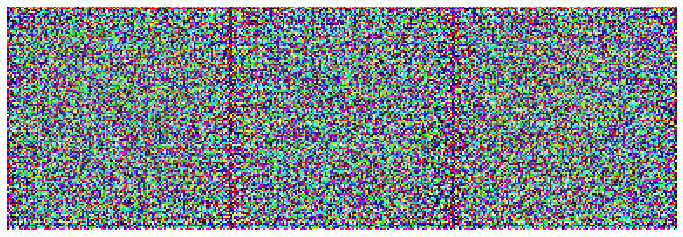

In [80]:
z = torch.randn(3, 64, 1, 1).to(device)
output = wnetG(z)

print("Noise input 1, 2, 3")
display_multiple_output(output.cpu())

Noise input 1, 2, 3


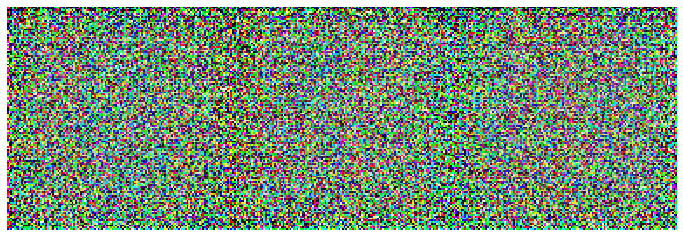

In [67]:
# Evidence 3 of mode collapse
dict_ID_3 = "1576014529"
model_collapse_model_3 = load_wmodel(dict_ID_3).to(device)
z = torch.randn(3, 64, 1, 1).to(device)
output = model_collapse_model_3(z)

print("Noise input 1, 2, 3")
display_multiple_output(output.cpu())

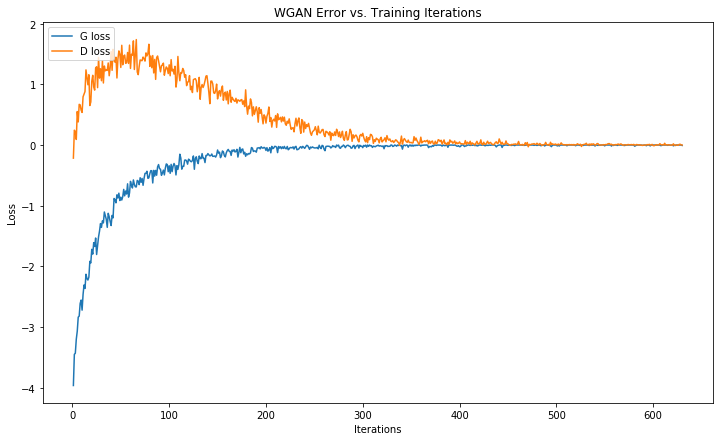

In [60]:
plot_loss(wlossG, wlossD, "WGAN")